# Evaluation exercise for Google Summer of Code / ATLAS autoencoders
This notebook has been adapted from the original in the repository with more documentation as well as possible areas of improvement. 

The evaluation task was to compress the dataset given from 4 variables, namely m, pt, phi and eta to 3 variables using an Autoencoder.

## 1. Importing the required libraries

The first step is to import the libraries we need to run this notebook.


Since I used Google Colab to run the notebook, we need to update the fastai library and install any other neccesary dependencies. This library is what has been used to train the network. The steps to bring the package to the latest version can be found [here](https://course.fast.ai/start_colab.html).

The command below automates the process.

In case the model is to be trained on your local machine, follow the steps mentioned in the README to install any other required.

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai
from fastai import train as tr

These are the user scripts with helper files that we use in this notebook. We are appending to the system path as these scripts are in the folder above this one.

`nn_utils.py`

Contains the different model architectures that were used to perform the compression. If you want to experiment with a different architecture, you will just need to define the model class in this file and import it in this notebook. 

`utils.py`

Contains functions to plot the statistics of the weights in the model, such as mean and std


In [0]:
import sys

BIN = '../'
sys.path.append(BIN)

from nn_utils import AE_big, AE_3D_200
from utils import plot_activations
import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

Checks if there is a GPU that can be used to speed up training. If it is, we can move the model to the GPU for training.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using %s for computation." % device)

Using cuda for computation.


The following lines are needed only if you are running the notebook in colab, else comment them out

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Data Loading and Normalisation
The train and test files should be present in the same folder as this notebook. If they are present somewhere else, you need to make the required changes to `train_location` and `test_location`.

In [6]:
train_location = 'train.pkl'
test_location = 'test.pkl'

train = pd.read_pickle(train_location)
test = pd.read_pickle(test_location)
n_features = len(train.loc[0])

train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


In [7]:
train.describe()

,m,pt,phi,eta
count,111778.000000,111778.000000,111778.000000,111778.000000
mean,8941.356799,64458.683471,0.001691,0.043500
std,7421.270111,69874.993026,1.803151,1.448439
min,-0.045353,20000.154297,-3.141587,-4.745398
25%,4658.248535,22514.718750,-1.558285,-1.139831
50%,5728.732910,27141.585938,0.019362,0.086258
75%,10467.514160,78976.080078,1.553306,1.178913
max,128247.671875,748795.937500,3.141546,4.747644


Using the statistics of the train split, we normalise the train and test sets. After this we create a TensorDataset. 

In [0]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float32), torch.tensor(train_y.values, dtype=torch.float32))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float32), torch.tensor(test_y.values, dtype=torch.float32))

A DataLoader automates the process  of getting batches from the dataset of the required batch size. Two dataloaders have been defined here, one for the training and the other for validation. 

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [0]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

The `Learner` object needs a DataBunch containing the data to train on. Both the training and validation dataloaders need to be passed to it as the `Learner` computes both train loss and validation loss at the end of each epoch.

In [0]:
db = basic_data.DataBunch(train_dl, valid_dl)

## 3. Defining the Model and the loss function
We can experiment with different loss functions to see which helps improve training. Uncomment the line of the loss function you wish to use for your training.

You can also define custom loss functions as given below and use them.

In [0]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

loss_func = nn.MSELoss()
#loss_func = RMSELoss()
#loss_func = my_loss_func

From the models that we imported from `nn_utils`, choose the one you wish to train. The line below that moves the model to the CPU or the GPU if available.

In [0]:
model = AE_3D_200()
model = model.to(device)

Here we are defining the `Learner` object with the required parameters. More parameters can also be passed and the documentation for the ones used here can be found in the [fastai docs](https://docs.fast.ai/basic_train.html#Learner). 

In [0]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In case you are resuming training after already having done it for a while, you can load your pre trained weights and continue training. Else comment out the line with `learn.load`

In [15]:
model_location = '/content/drive/My Drive/AE'
learn.load(model_location)

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f26162f05c0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f26162f06a0>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

fastai has a convinience function that helps you find an ideal learning rate. It does this by running one eoch using several different learning rates and computing the loss for each of the different rates.

This can be coded from scratch too, but it simplifies the process. The plot of LR vs Loss can be shown using `recorder.plot()`

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


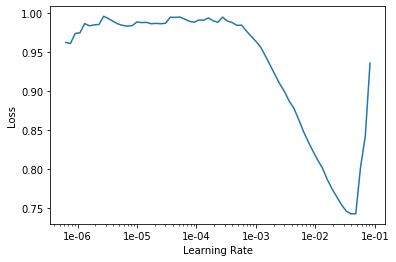

In [0]:
learn.recorder.plot()

## 4. Training
The cells below are just repetitions with learning rate being reduced over time. The validation loss is also plotted.

After a set number of epochs, the model is saved to disk.

In [0]:
lr = 3e-3
learn.fit(50, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.035876,0.034368,00:03
1,0.030596,0.032433,00:04
2,0.027733,0.028178,00:03
3,0.024779,0.023932,00:03
4,0.022617,0.022849,00:03
5,0.021046,0.021844,00:03
6,0.021492,0.020096,00:04
7,0.019605,0.019774,00:03
8,0.017857,0.021852,00:04
9,0.019164,0.021089,00:04


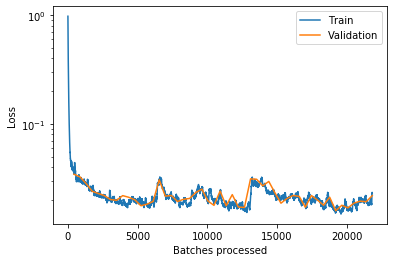

In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

The statistics of the weights are plotted for each mini-batch. The mean and standard deviation of the weights of each layer are given.

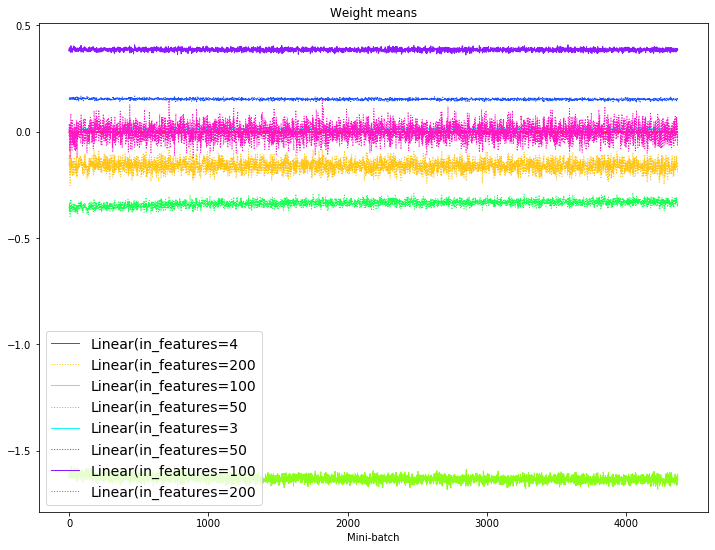

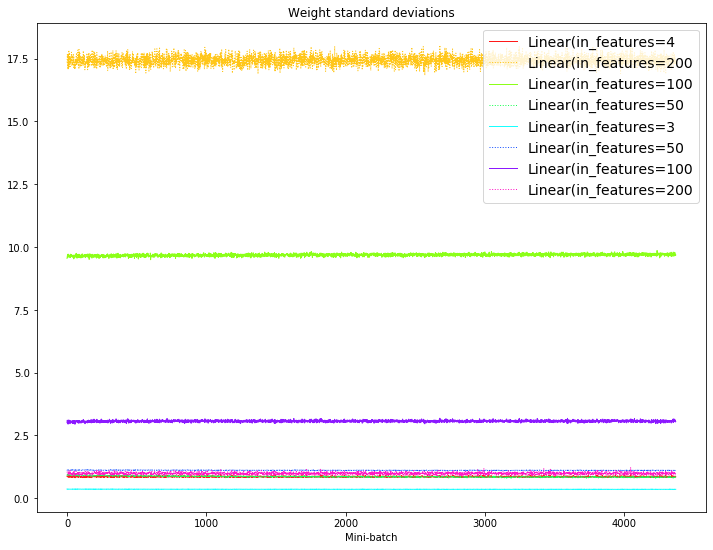

In [0]:
plot_activations(learn)

In [0]:
lr = 1e-5
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.016127,0.016553,00:03
1,0.015929,0.016206,00:03
2,0.015118,0.016000,00:03
3,0.014980,0.015882,00:04
4,0.015450,0.015788,00:04
5,0.015061,0.015707,00:03
6,0.015171,0.015636,00:03
7,0.015484,0.015585,00:03
8,0.014825,0.015530,00:04
9,0.014825,0.015459,00:03


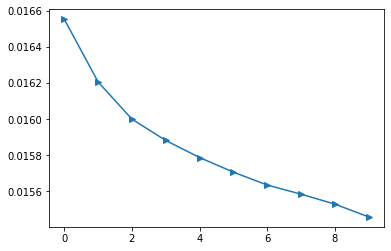

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')

In [0]:
lr = 1e-6
learn.fit(200, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010043,0.010227,00:04
1,0.009854,0.010228,00:04
2,0.009871,0.010226,00:04
3,0.009992,0.010226,00:04
4,0.010192,0.010226,00:04
5,0.009757,0.010225,00:04
6,0.009840,0.010225,00:04
7,0.009832,0.010227,00:04
8,0.010181,0.010225,00:04
9,0.009710,0.010226,00:04


epoch,train_loss,valid_loss,time
0,0.010118,0.010641,00:03
1,0.010564,0.010631,00:03
2,0.009925,0.010629,00:03
3,0.010304,0.010624,00:03
4,0.010192,0.010640,00:03
5,0.010193,0.010622,00:03
6,0.010127,0.010614,00:03
7,0.010321,0.010623,00:03
8,0.010337,0.010625,00:03
9,0.010178,0.010615,00:03


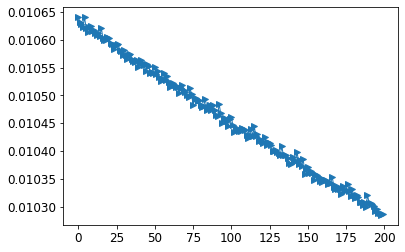

In [0]:
lr = 5e-6
learn.fit(200, lr=lr, wd=wd)
plt.plot(learn.recorder.val_losses, marker='>')
learn.save(model_location)

In [19]:
lr = 4e-6
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.007930,0.008936,00:05
1,0.007707,0.008913,00:05
2,0.007782,0.008906,00:05
3,0.007931,0.008913,00:05
4,0.007956,0.008900,00:05
5,0.007977,0.008883,00:05
6,0.007828,0.008891,00:05
7,0.008259,0.008885,00:05
8,0.007843,0.008883,00:05
9,0.007754,0.008883,00:05


In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

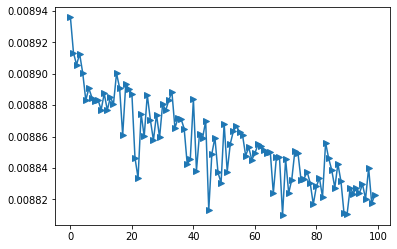

In [24]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
learn.save(model_location)

In [26]:
lr = 1e-6
learn.fit(200, lr=lr, wd=wd)
plt.plot(learn.recorder.val_losses, marker='>')
learn.save(model_location)

epoch,train_loss,valid_loss,time
0,0.007414,0.008725,00:05
1,0.007240,0.008721,00:06
2,0.007535,0.008719,00:06
3,0.007755,0.008719,00:05
4,0.007204,0.008726,00:05
5,0.007767,0.008718,00:05
6,0.007651,0.008717,00:05
7,0.007540,0.008719,00:06
8,0.007327,0.008719,00:05
9,0.007574,0.008719,00:06


KeyboardInterrupt: ignored

In [0]:
lr = 1e-6
learn.fit(200, lr=lr, wd=wd)
plt.plot(learn.recorder.val_losses, marker='>')
learn.save(model_location)

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 5e-6
learn.fit(500, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

## 5. Training forever
Grouping these together since they are just copies. By running these cells, you would have trained for about 14000 epochs.

In [0]:
lr = 3e-6
learn.fit(100, lr=lr, wd=wd)

In [0]:
learn.recorder.plot_losses()
#plt.yscale('log')

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
learn.load('AE_3D_200_no1cycle_trainforever')

In [0]:
lr = 3e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
learn.save('AE_3D_200_no1cycle_trainforever')

In [0]:
learn.load('AE_3D_200_no1cycle_trainforever')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>')
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [0]:
lr = 1e-6
learn.fit(1000, lr=lr, wd=wd)

In [0]:
plt.plot(learn.recorder.val_losses, marker='>', label='Validation')
plt.legend()
#plt.yscale('log')

In [0]:
learn.save(model_dir)

## 6. Analysis 
Once training is done, we can look at how well the Autoencoder performs in reconstructing the compressed data. First we load the trained weights and check the current validation loss.

In [0]:
learn.load(model_dir)

In [23]:
learn.validate()

[0.008822895]

In [0]:
curr_save_folder = 'trainforever_plots/'

First choose the data points that we shall compress and decompress. 

`pred` contains the decompressed data. Since while training we had normalised the data to zero mean and unit standard deviations, we convert them back to their original forms by adding the original mean and multiplying the standard deviation.

In [0]:
model.to('cpu')

idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float32)
pred = model(data).detach().numpy()

# Denormalisation
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)

data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

These are the `matplotlib` plot style parameters. They can be changed to effect the style of the plots below. 

In [0]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']
alph = 0.8
n_bins = 50
curr_save_folder = '/content/drive/My Drive/GSoC/CERN/plots/'

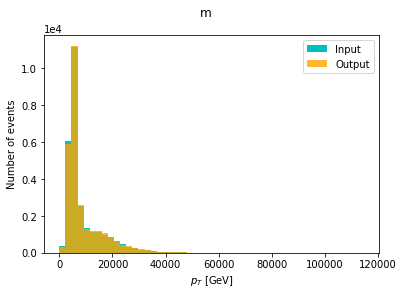

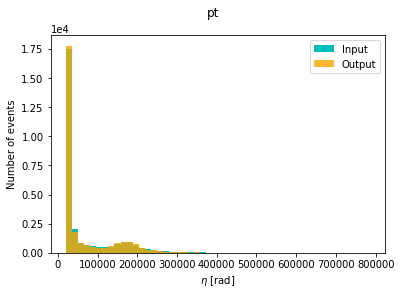

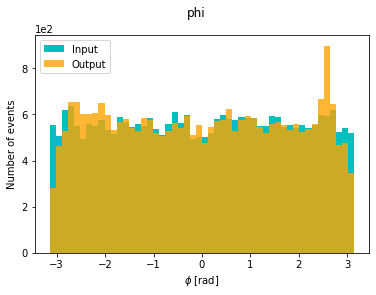

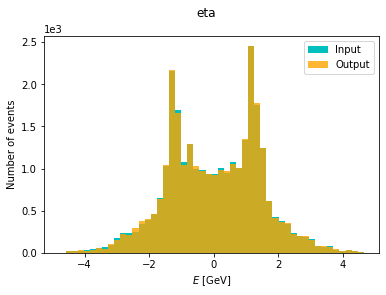

In [0]:
for kk in np.arange(4):
    plt.figure(kk + 4)
    
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    
    fig_name = 'AE_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

**Residuals of the Variables**

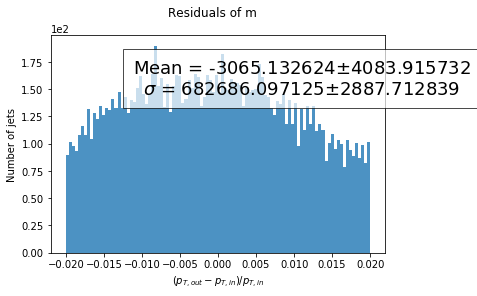

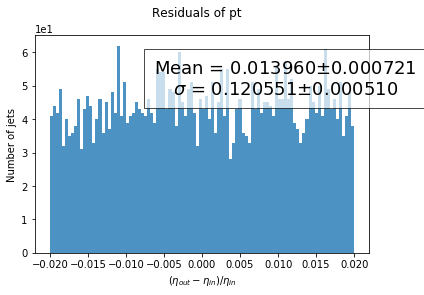

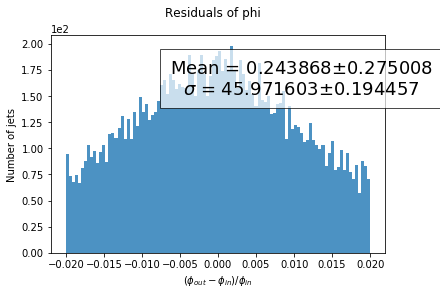

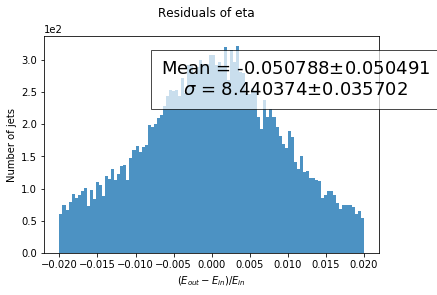

In [0]:
import utils
from scipy import stats

residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()

range = (-.4, .4)
#range=None
for kk in np.arange(4):
    plt.figure()

    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)

    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')

    ms.sciy()
    #plt.yscale('log')

    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()

    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

    fig_name = 'AE_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

**MSE Loss Plots**

In [0]:
MSE_strings = [r'$(p_{T,out} - p_{T,in})^{2}$',
                        r'$(\eta_{out} - \eta_{in})^{2}$',
                        r'$(\phi_{out} - \phi_{in})^{2}$',
                        r'$(E_{out} - E_{in})^{2}$']

loss = nn.MSELoss(reduction='none')
MSELoss = loss(torch.tensor(pred), data)
range = [(0, 2), (0, 2), (0, .5), (0, .2)]
#range=None
for kk in np.arange(4):

    plt.figure()

    n_hist_pred, bin_edges, _ = plt.hist(
        MSELoss[:, kk], label='Mean Square Loss', linestyle=line_style[0], alpha=alph, bins=100, range=range[kk])

    plt.suptitle('MSE Loss of %s' % train.columns[kk])
    plt.xlabel(MSE_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')

    ms.sciy()
    #plt.yscale('log')

    std = MSELoss.std(dim=0)[kk]
    std_err = utils.std_error(MSELoss[:, kk])
    mean = np.nanmean(MSELoss[:, kk])
    sem = stats.sem(MSELoss[:, kk], nan_policy='omit')
    ax = plt.gca()

    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

    fig_name = 'AE_MSELoss_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

**RMSE Loss**

In [0]:
RMSE_strings = [r'$\sqrt{(p_{T,out} - p_{T,in})^{2}}$',
                        r'$\sqrt{(\eta_{out} - \eta_{in})^{2}}$',
                        r'$\sqrt{(\phi_{out} - \phi_{in})^{2}}$',
                        r'$\sqrt{(E_{out} - E_{in})^{2}}$']

loss = nn.MSELoss(reduction='none')
MSELoss = loss(torch.tensor(pred), data)
RMSELoss = torch.sqrt(MSELoss)

for kk in np.arange(4):
    plt.figure()

    n_hist_pred, bin_edges, _ = plt.hist(
        RMSELoss[:, kk], label='Root Mean Square Loss', linestyle=line_style[0], alpha=alph, bins=100)

    plt.suptitle('RMSE Loss of %s' % train.columns[kk])
    plt.xlabel(RMSE_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')

    ms.sciy()
    #plt.yscale('log')

    std = RMSELoss.std(dim=0)[kk]
    std_err = utils.std_error(RMSELoss[:, kk])
    mean = np.nanmean(RMSELoss[:, kk])
    sem = stats.sem(RMSELoss[:, kk], nan_policy='omit')

    ax = plt.gca()

    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'AE_RMSELoss_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

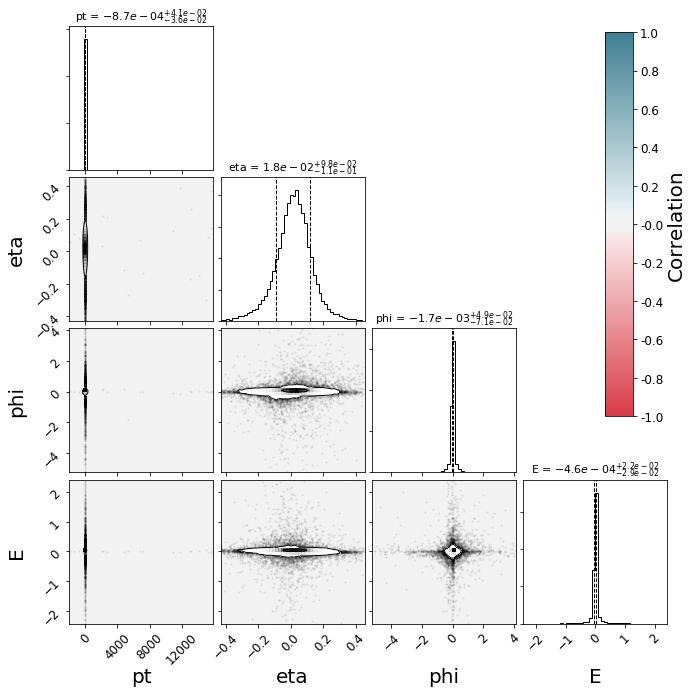

In [0]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'pt': residuals[:, 0], 'eta': residuals[:, 1], 'phi': residuals[:, 2], 'E': residuals[:, 3]})
save = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['pt', 'eta', 'phi', 'E']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]

figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'

# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))

cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)